In [1]:
import sys
sys.path.append("/home/ubuntu/workspaces/deepinv/")

In [2]:
import deepinv as dinv
from pathlib import Path
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity
from deepinv.models.complex import to_complex_denoiser

In [3]:
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 11629 MB free memory 


device(type='cuda', index=0)

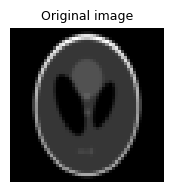

In [4]:
# Set up the variable to fetch dataset and operators.
img_size = 50
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)

plot(x, titles="Original image")

In [5]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [6]:
time1 = time.time()
physics = dinv.physics.RandomPhaseRetrieval(
                m=12500,
                img_shape=(1,50,50),
                noise_model=dinv.physics.GaussianNoise(sigma=0.05),
                device=device,
            )
time2 = time.time()
print(x_phase.device)
print(physics.device)

y = physics(x_phase)
time3 = time.time()
print("Time to create physics object: ", time2-time1)
print("Time to create data: ", time3-time2)

cuda:0
cuda:0
Time to create physics object:  10.349229335784912
Time to create data:  0.2836461067199707


In [7]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

time1 = time.time()

A = torch.randn((1000, 1000), device=device, dtype=torch.float) / np.sqrt(1000000)

time2 = time.time()

A_dagger = torch.linalg.pinv(A)

time3 = time.time()

print("Time to create A: ", time2-time1)
print("Time to compute A_dagger: ", time3-time2)

Selected GPU 0 with 10173 MB free memory 
Time to create A:  0.0005650520324707031
Time to compute A_dagger:  0.36705732345581055
